# 0. 번역기를 만들어 보자

영어를 프랑스어로 바꿔주는 번역기를 만들어 보자.

In [1]:
import os, re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Embedding, LSTM, Masking, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping

# 1. 데이터 불러오기

https://www.manythings.org/anki/  
이 곳에서 데이터를 다운 받을 수 있다.

In [2]:
file_path = os.getenv('HOME') + '/aiffel/translator_seq2seq/data/fra.txt'
data = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(data))
data.sample(5)

전체 샘플의 수 : 197463


,eng,fra,cc
129382,I am losing my patience with you.,Je perds patience avec vous.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
90794,Tom always tells the truth.,Tom dit toujours la vérité.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
16344,Tom looked back.,Tom a regardé en arrière.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
184310,We were reading a book and it was a very good ...,Nous lisions un livre qui était très bon.,CC-BY 2.0 (France) Attribution: tatoeba.org #7...
41977,How did you get hurt?,Comment vous êtes-vous blessés ?,CC-BY 2.0 (France) Attribution: tatoeba.org #1...


필요없는 열을 제거하고 데이터를 위에서 33000개만 가져온다.

In [3]:
data = data[['eng', 'fra']][: 33000]
data.sample(5)

,eng,fra
19878,Keep a cool head.,Gardez la tête froide.
6731,Can he see me?,Peut-il me voir ?
13614,Go home quickly.,Rentre vite à la maison.
5865,Take it easy.,Ne t'en fais pas.
15929,They were lucky.,Elles eurent de la chance.


# 2. 정제, 정규화, 전처리하기

전처리한 후 토큰화시켜주는 함수를 생성한다.

In [4]:
def pretoken_sentence(sentence): # 토큰화를 하기 전 문장 정제
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 구두점(Punctuation)을 단어와 분리
    
    sentence = sentence.lower() # 소문자로 바꾸기
    
    sentence = sentence.split() # 띄어쓰기 단위로 토큰을 수행
    
    return sentence

In [5]:
pretoken_sentence('   I am    happy.  ')

['i', 'am', 'happy', '.']

전처리가 잘 되는 모습이다. 실제로 적용해보자.

In [6]:
eng_tokens = data['eng'].apply(pretoken_sentence)
fra_tokens = data['fra'].apply(pretoken_sentence)

In [7]:
print(eng_tokens)
print(fra_tokens)

0                            [go, .]
1                            [go, .]
2                            [go, .]
3                            [go, .]
4                            [hi, .]
                    ...             
32995    [we, all, cried, a, lot, .]
32996     [we, all, felt, hungry, .]
32997     [we, also, found, this, .]
32998     [we, are, busy, people, .]
32999     [we, are, watching, tv, .]
Name: eng, Length: 33000, dtype: object
0                                           [va, !]
1                                       [marche, .]
2                                    [en, route, !]
3                                        [bouge, !]
4                                        [salut, !]
                            ...                    
32995    [nous, avons, toutes, beaucoup, pleuré, .]
32996                 [nous, avions, tous, faim, .]
32997         [nous, avons, aussi, trouvé, ceci, .]
32998         [nous, sommes, des, gens, occupés, .]
32999          [nous, regardons, 

역시나 잘 적용되는 모습.

# 3. 디코더의 문장에 시작 토큰과 종료 토큰을 넣어주기

토큰의 양 옆에 시작 토큰과 종료 토큰을 넣어준다.

In [8]:
sos_token = '\t'
eos_token = '\n'
fra_tokens = fra_tokens.apply(lambda x: [sos_token] + x + [eos_token])
print('전체 샘플의 수 :',len(fra_tokens))
fra_tokens.sample(5)

전체 샘플의 수 : 33000


12250            [\t, tom, semble, être, mort, ., \n]
31107    [\t, c'est, notre, unique, spectacle, ., \n]
30578                         [\t, j'ai, faim, ., \n]
13925            [\t, je, suis, très, fatigué, ., \n]
6147                    [\t, tom, les, a, vus, ., \n]
Name: fra, dtype: object

디코더의 input token에는 토큰에서 종료 토큰을 빼고 output token에는 토큰에서 시작 토큰을 빼고 다시 넣는다.

In [9]:
fra_tokens_input = fra_tokens.apply(lambda x: x[: -1])
fra_tokens_output = fra_tokens.apply(lambda x: x[1: ])
print(fra_tokens_input)
print(fra_tokens_output)

0                                           [\t, va, !]
1                                       [\t, marche, .]
2                                    [\t, en, route, !]
3                                        [\t, bouge, !]
4                                        [\t, salut, !]
                              ...                      
32995    [\t, nous, avons, toutes, beaucoup, pleuré, .]
32996                 [\t, nous, avions, tous, faim, .]
32997         [\t, nous, avons, aussi, trouvé, ceci, .]
32998         [\t, nous, sommes, des, gens, occupés, .]
32999          [\t, nous, regardons, la, télévision, .]
Name: fra, Length: 33000, dtype: object
0                                           [va, !, \n]
1                                       [marche, ., \n]
2                                    [en, route, !, \n]
3                                        [bouge, !, \n]
4                                        [salut, !, \n]
                              ...                      
32995   

# 4. 케라스의 토크나이저로 텍스트를 숫자로 바꿔보기

토큰화는 되어 있지만 훈련을 위해 숫자로 바꿔줘야한다.

In [10]:
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(eng_tokens)
encoder_input = eng_tokenizer.texts_to_sequences(eng_tokens)
encoder_input[:3]

[[25, 1], [25, 1], [25, 1]]

In [11]:
fra_tokenizer = Tokenizer()
fra_tokenizer.fit_on_texts(fra_tokens)
decoder_input = fra_tokenizer.texts_to_sequences(fra_tokens_input)
decoder_output = fra_tokenizer.texts_to_sequences(fra_tokens_output)

In [12]:
print(decoder_input[: 3])
print(decoder_output[: 3])

[[1, 62, 7], [1, 346, 3], [1, 25, 504, 7]]
[[62, 7, 2], [346, 3, 2], [25, 504, 7, 2]]


디코더의 인풋데이터의 각 샘플의 첫번 째 값은 1인데 이것은 sos 토큰의 인덱스고  
아웃풋데이터의 각 샘플의 마지막 값은 2인데 이것은 eos 토큰의 인덱스다.

In [13]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 4812
프랑스어 단어장의 크기 : 9983


In [14]:
max_eng_seq_len = max([len(line) for line in encoder_input])
max_fra_seq_len = max([len(line) for line in decoder_input])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 14


In [15]:
print('전체 샘플의 수 :',len(data))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 33000
영어 단어장의 크기 : 4812
프랑스어 단어장의 크기 : 9983
영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 14


In [16]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_output = pad_sequences(decoder_output, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_output))

영어 데이터의 크기(shape) : (33000, 8)
프랑스어 입력데이터의 크기(shape) : (33000, 14)
프랑스어 출력데이터의 크기(shape) : (33000, 14)


비슷한 데이터들이 근처에 포진되어 있어서 shuffle을 해야될 것 같다.

In [17]:
shuffle_nums = np.arange(len(encoder_input))
np.random.shuffle(shuffle_nums)

encoder_input = encoder_input[shuffle_nums]
decoder_input = decoder_input[shuffle_nums]
decoder_output = decoder_output[shuffle_nums]

실제로 shuffle을 한 모델과 안 한 모델의 validation 정확도가 5% 정도 차이가 난다.

In [60]:
n_of_val = 3000

encoder_input_train = encoder_input[: -n_of_val]
decoder_input_train = decoder_input[: -n_of_val]
decoder_output_train = decoder_output[: -n_of_val]

print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input_train))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input_train))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_output_train))

영어 학습데이터의 크기(shape) : (30000, 8)
프랑스어 학습 입력데이터의 크기(shape) : (30000, 14)
프랑스어 학습 출력데이터의 크기(shape) : (30000, 14)


In [61]:
encoder_input_test = encoder_input[-n_of_val: ]
decoder_input_test = decoder_input[-n_of_val: ]
decoder_output_test = decoder_output[-n_of_val: ]

print('영어 테스트데이터의 크기(shape) :',np.shape(encoder_input_test))
print('프랑스어 테스트 입력데이터의 크기(shape) :',np.shape(decoder_input_test))
print('프랑스어 테스트 출력데이터의 크기(shape) :',np.shape(decoder_output_test))

영어 테스트데이터의 크기(shape) : (3000, 8)
프랑스어 테스트 입력데이터의 크기(shape) : (3000, 14)
프랑스어 테스트 출력데이터의 크기(shape) : (3000, 14)


학습 데이터와 검증 데이터를 30000: 3000으로 나눈다.

# 5. 임베딩 층(Embedding layer) 사용하기

임베딩과 lstm 레이어의 차원을 적당히 잡아준다.

In [20]:
hidden_output_dim = 256
hidden_units = 256

In [21]:
encoder_emb = Embedding(eng_vocab_size, hidden_output_dim)
decoder_emb = Embedding(fra_vocab_size, hidden_output_dim)

# 6. 모델 구현하기

In [22]:
encoder_inputs = Input(shape=(None, ))
enc_emb = encoder_emb(encoder_inputs)
encoder_lstm = LSTM(hidden_units, return_state=True)
encoder_outputs, *encoder_states = encoder_lstm(enc_emb)

In [23]:
decoder_inputs = Input(shape=(None, ))
dec_emb = decoder_emb(decoder_inputs)
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True)
decoder_outputs, *_ = decoder_lstm(dec_emb, initial_state=encoder_states)

decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

In [24]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 256)    1231872     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 256)    2555648     input_2[0][0]                    
______________________________________________________________________________________________

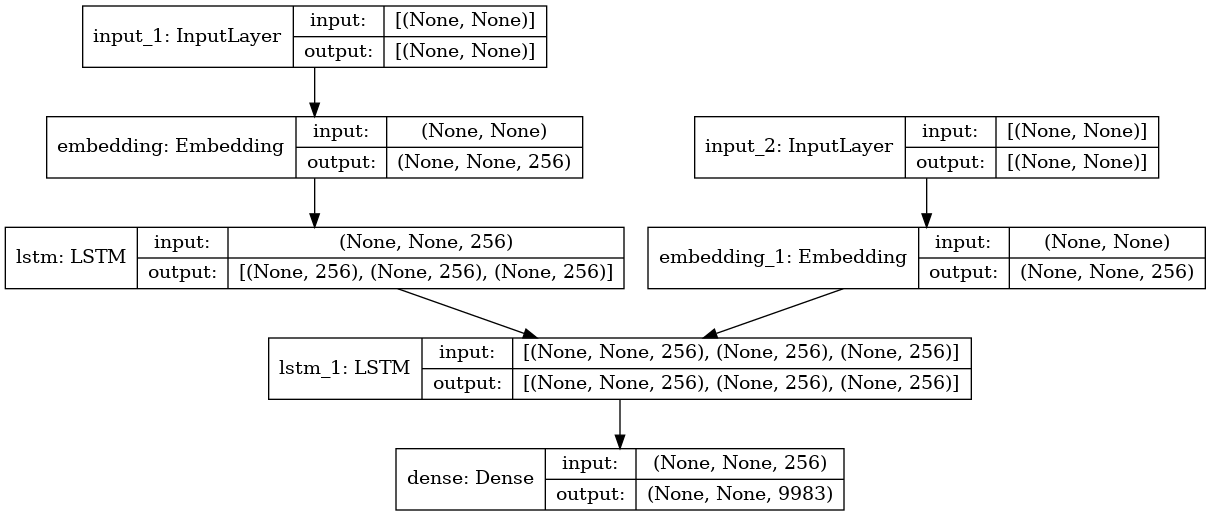

In [25]:
plot_model(model, show_shapes=True)

신경망 레이어가 어떻게 쌓여있는지 아주 쉽게 표현해주는 프린팅 함수.

학습이 더 이상 거의 진행되지 않으면 중단시켜주는 early stop 기능 사용.

In [26]:
early_stop = EarlyStopping(monitor='val_loss', verbose=1, patience=10)

history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_output_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_output_test),
          batch_size=128, epochs=50, callbacks=[early_stop])


Epoch 1/50
235/235 [==============================] - 12s 32ms/step - loss: 2.4785 - accuracy: 0.6674 - val_loss: 1.8112 - val_accuracy: 0.7382
Epoch 2/50
235/235 [==============================] - 7s 29ms/step - loss: 1.6840 - accuracy: 0.7448 - val_loss: 1.6319 - val_accuracy: 0.7472
Epoch 3/50
235/235 [==============================] - 7s 29ms/step - loss: 1.5137 - accuracy: 0.7566 - val_loss: 1.4901 - val_accuracy: 0.7684
Epoch 4/50
235/235 [==============================] - 7s 29ms/step - loss: 1.3550 - accuracy: 0.7804 - val_loss: 1.3702 - val_accuracy: 0.7855
Epoch 5/50
235/235 [==============================] - 7s 29ms/step - loss: 1.2302 - accuracy: 0.7966 - val_loss: 1.2746 - val_accuracy: 0.8013
Epoch 6/50
235/235 [==============================] - 7s 29ms/step - loss: 1.1141 - accuracy: 0.8123 - val_loss: 1.1926 - val_accuracy: 0.8159
Epoch 7/50
235/235 [==============================] - 7s 30ms/step - loss: 1.0154 - accuracy: 0.8245 - val_loss: 1.1252 - val_accuracy: 0.822

에포크가 36을 돌파하는 순간 val accuracy 87% 달성하고 멈추었다.

에포크마다 학습이 잘 진행되고 있는지 알려주는 함수 생성.

In [27]:
def history_plot(history):
    y_acc = history.history['accuracy']
    y_vacc = history.history['val_accuracy']
    
    y_loss = history.history['loss']
    y_vloss = history.history['val_loss']

    epochs_range = range(len(y_acc))

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, y_acc, marker='.', label="Train-set accuracy")
    plt.plot(epochs_range, y_vacc, marker='.', label="Validation-set accuracy")
    plt.legend(loc='lower right')
    plt.grid()
    plt.ylim(0.5, 1) 
    plt.title('Accurcy graph with batch normalization') 
    plt.xlabel('epoch')
    plt.ylabel('accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, y_loss, marker='.', label="Train-set Loss")
    plt.plot(epochs_range, y_vloss, marker='.', label="Validation-set Loss")
    plt.legend(loc='upper right')
    plt.grid()
    plt.title('Loss graph with batch normalization') 
    plt.xlabel('epoch')
    plt.ylabel('loss')
    
    plt.show()

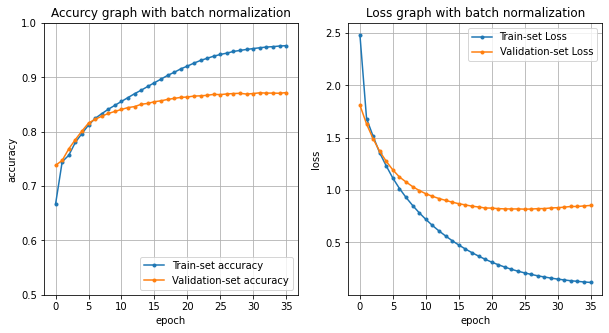

In [28]:
history_plot(history)

# 7. 모델 평가하기

모델을 테스트할 때는 학습할 때랑은 다른 방식으로 인코더와 디코더를 만들어야 한다.  
왜냐하면 학습할 때와는 다르게 테스트할 때에는 예측한 값을 바로 뒤 스템의 인풋으로 넣기 때문이다.

In [29]:
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 256)         1231872   
_________________________________________________________________
lstm (LSTM)                  [(None, 256), (None, 256) 525312    
Total params: 1,757,184
Trainable params: 1,757,184
Non-trainable params: 0
_________________________________________________________________


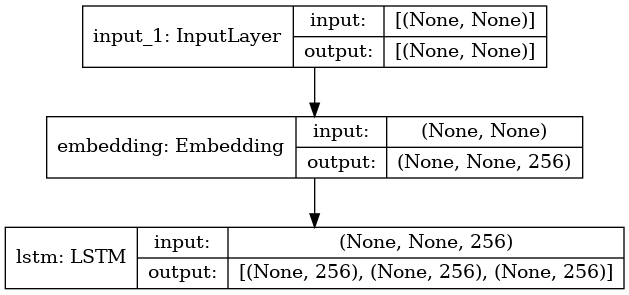

In [36]:
plot_model(encoder_model, show_shapes=True)

In [30]:
decoder_state_input_h = Input(shape=(hidden_units, ))
decoder_state_input_c = Input(shape=(hidden_units, ))

decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, *decoder_states = decoder_lstm(dec_emb, initial_state = decoder_states_inputs)

In [31]:
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 256)    2555648     input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256)]        0                                            
____________________________________________________________________________________________

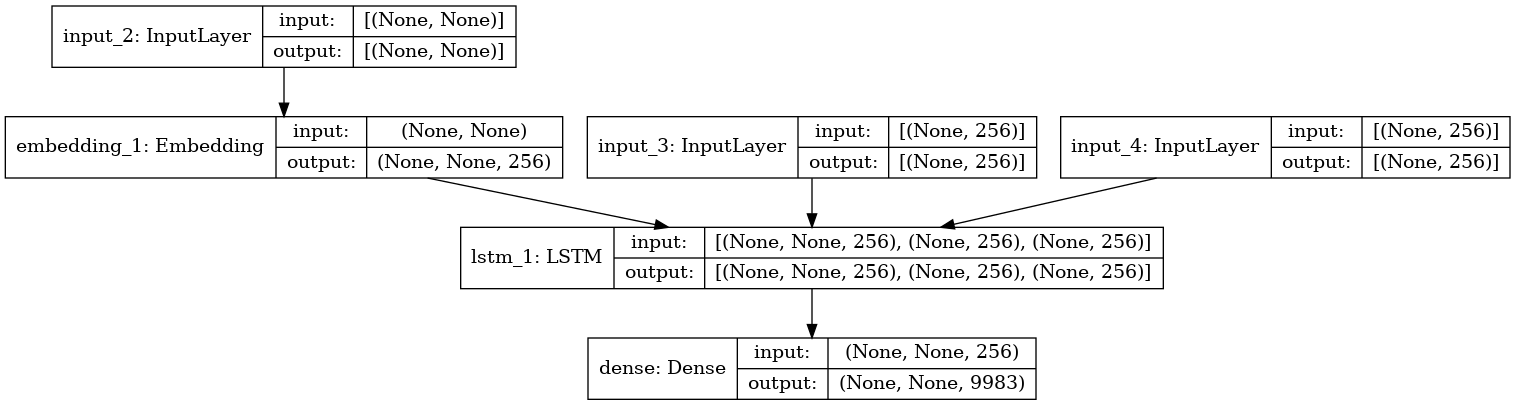

In [37]:
plot_model(decoder_model, show_shapes=True)

In [32]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

워드와 인덱스를 변환해주는 딕셔너리 저장.

In [34]:
data_eng_shuffle = data.eng[shuffle_nums].reset_index(drop=True)
data_fra_shuffle = data.fra[shuffle_nums].reset_index(drop=True)

학습할 때 데이터를 shuffle해서 집어넣었기 때문에 번역을 한 후 기존 문장과 비교하려면  
기존 문장도 같은 인덱스를 추출해야 한다.

번역 함수 생성. 중요한 점은 디코더의 출력값이 다음 스템의 인풋값이 되기 때문에  
while 문을 이용해서 수동적으로 번역을 해줘야한다.

In [56]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # 에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1,1)) 
    target_seq[0, 0] = fra2idx[sos_token]
    
    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        
        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += ' ' + sampled_char

        # 에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == eos_token):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장     
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [58]:
for seq_index in [3,50,100,300,1001]: # 입력 문장의 인덱스 (자유롭게 선택해 보세요)
    input_seq = encoder_input[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', data_eng_shuffle[seq_index])
    print('정답 문장:', data_fra_shuffle[seq_index][: ])
    print('번역기가 번역한 문장:', decoded_sentence[1: -1])

-----------------------------------
입력 문장: I'm so embarrassed.
정답 문장: Je suis tellement embarrassée.
번역기가 번역한 문장: je suis tellement embarrassé . 
-----------------------------------
입력 문장: I'll go.
정답 문장: J'irai.
번역기가 번역한 문장: j'irai . 
-----------------------------------
입력 문장: I just need a hug.
정답 문장: J'ai juste besoin d'un câlin.
번역기가 번역한 문장: j'ai juste besoin d'un câlin . 
-----------------------------------
입력 문장: I'm totally drunk.
정답 문장: Je suis complètement saoul.
번역기가 번역한 문장: je suis complètement saoul . 
-----------------------------------
입력 문장: I was threatened.
정답 문장: J'ai été menacé.
번역기가 번역한 문장: on m'a menacé . 


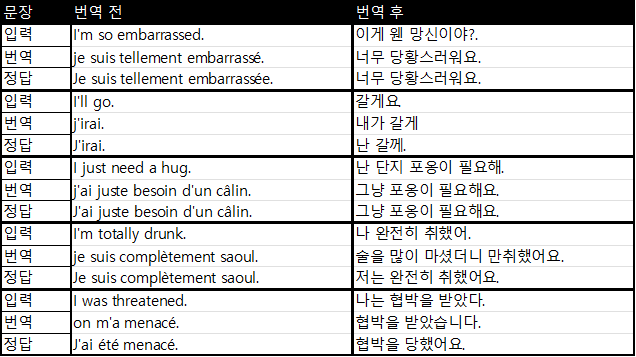

번역이 매우 잘 된 모습이다. 기대 이상이었다.

하자가 있다면 파파고의 성능이 문제라는 것.  
"I'm so embarrassed."의 번역은 "이게 웬 망인이야?." 가 아니라 "너무 당황스러워요."가 맞는 것 같다.  

# 8. 회고하기

## 8.1. 이번 프로젝트에서 어려웠던 점

이번에 10번 노드는 페이지의 내용을 다 이해를 못(+안)하고 프로젝트를 들어가서 역대급으로 어려웠다.  
또한 val_accuracy가 매우 안나오는 문제가 발생했었는데  
첫번째 이유는 시간이 아까운 나머지 batch size를 1024로 줬던 점이고,  
두번째 이유는 비슷한 데이터들이 뭉쳐있었기 때문이고,  
세번째 이유는 pad_sequences의 padding 하이퍼 파라미터를 'pre'로 줬던 점이다.  
특히 두번째 이유를 shuffle로 해결하니 바로 5%가 상승되었다.  
이 문제를 해결하기 위해 3시간을 공들여 우재 그루님의 코드와 내 코드를 한 블럭마다 바꿔가며  
accuracy를 비교했었다. shuffle을 하면 좋겠다만 생각하고 accuracy가 그래도 별로 차이가 안날 줄 알았는데  
차이가 매우 많이 나서 깜짝 놀랐다.  
승욱 그루님은 아예 상위 33000개가 아니라 랜덤으로 샘플링하는 방법으로 val_loss값을 내 1.5배 낮게 나오게 하셨다.

인코더 디코더 방식의 모델이 학습할 때와 평가할 때 다르게 쌓는 방법도 어려웠다.

## 8.2. 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점

인코더 디코더 방식의 모델을 아직까지는 내가 직접 쌓지는 못할 것 같다.  
이 회고를 마치고 다시 10번 노드를 볼 예정이다.

## 8.3. 루브릭 평가 지표를 맞추기 위해 시도한 것들

점수를 맞추는 것이 아니라서 딱히 뭔가를 시도한다기 보다는  
어떻게 글자 단위 번역기에서 단어 단위 번역기로 바꿀 수 있는지가 관건이었던 것 같다.

## 8.4. 만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정

인코더 디코더 방식의 모델을 이해하냐 못하냐로 갈릴 것 같다.

## 8.5. 회상 혹은 자기 다짐

내가 cv와 nlp중 nlp를 선택하게 해준 노드다.  
전처리를 하는데 왠지 모를 개운함을 느꼈다.  
역대급으로 힘든 노드였는데 마지막에 잘 번역된 문장을 보니까  
마치 어려운 수학 문제를 풀었을 때 처럼 폭발적인 희열감을 느꼈다.